本程式碼應用movielens 的資料集，講解如何利用深度學習構造推薦系統模型。推薦系統的目標函數有很多，比如推薦評分最高的，或者推薦點擊率最高的等等。有時候我們還會兼顧推薦內容的多樣性。我們在這裡講解的是最根本的基於使用者給內容打分的情形。這裡的核心思想是對使用者和內容建模，從而預測使用者對未看過內容的打分。推薦系統進而會把預測的高分內容呈現給使用者。

In [1]:
import mathp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense, Reshape
from keras.layers.merge import Dot, Concatenate
from keras.models import Model, Input

Using CNTK backend
C:\Anaconda3\lib\site-packages\keras\backend\cntk_backend.py:21: UserWarning: CNTK backend warning: GPU is not detected. CNTK's CPU version is not fully optimized,please run with GPU to get better performance.
  'CNTK backend warning: GPU is not detected. '


依常規，我們首先得進行探索性分析，看看資料集和評分分佈長什麼樣子的。借此我們還要計算評分稀疏性，因為所有的推薦系統都是基於大量缺失資料的。在這裡，我們的思路是預測整個評分表，把缺失資料還原。

[6040, 3952, 1000209]


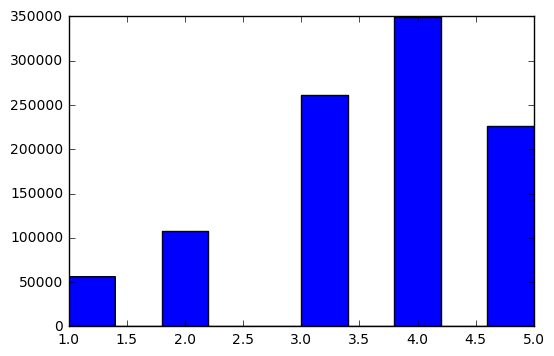

3.581564453029317


In [2]:
ratings = pd.read_csv('./data/ratings.dat', sep = '::', \
    engine='python',names = ['user_id','movie_id','rating','timestamp'])
n_users = np.max(ratings['user_id'])
n_movies = np.max(ratings['movie_id'])
print([n_users, n_movies, len(ratings)])

plt.hist(ratings['rating'])
plt.show()
print(np.mean(ratings['rating']))


接下來我們進行對使用者和內容的建模，使用的是我們熟悉的Emdbedding思想。我們使用的Embedding維度為128。讀者可以自行調整。

In [3]:
k = 128    
model1 = Sequential()
model1.add(Embedding(n_users + 1, k, input_length = 1))
model1.add(Reshape((k,)))
model2 = Sequential()
model2.add(Embedding(n_movies + 1, k, input_length = 1))
model2.add(Reshape((k,)))

In [4]:
model2.input, model2.output

(Input('embedding_2_input', [#], [1]),
 Composite(Reshape): Input('embedding_2_input', [#], [1]) -> Output('Reshape21_Output_0', [#], [128]))

我們的思路是通過計算使用者和內容的向量乘積，得出評分。

In [5]:
model = Sequential()
m = Dot(axes=1)([model1.output, model2.output])
model_output = m
model = Model([model1.input, model2.input], model_output)
model.compile(loss = 'mse', optimizer = 'adam')
#model.compile(loss = 'mse', optimizer = 'rmsprop')
#model.compile(loss = 'mse', optimizer = 'adagrad')

準備好訓練資料，代入模型。

In [6]:
users = ratings['user_id'].values
movies = ratings['movie_id'].values
X_train = [users, movies]
y_train = ratings['rating'].values

In [7]:
model.fit(X_train, y_train, batch_size = 500, epochs = 10)

Epoch 1/10
1000209/1000209 [==============================] - 105s 105us/step - loss: 4.2212
Epoch 2/10
1000209/1000209 [==============================] - 96s 96us/step - loss: 0.8128
Epoch 3/10
1000209/1000209 [==============================] - 90s 90us/step - loss: 0.7381
Epoch 4/10
1000209/1000209 [==============================] - 96s 96us/step - loss: 0.6741
Epoch 5/10
1000209/1000209 [==============================] - 103s 103us/step - loss: 0.6096
Epoch 6/10
1000209/1000209 [==============================] - 103s 103us/step - loss: 0.5410
Epoch 7/10
1000209/1000209 [==============================] - 104s 104us/step - loss: 0.4718
Epoch 8/10
1000209/1000209 [==============================] - 110s 110us/step - loss: 0.4073
Epoch 9/10
1000209/1000209 [==============================] - 107s 107us/step - loss: 0.3527
Epoch 10/10
1000209/1000209 [==============================] - 112s 112us/step - loss: 0.3085


我們看下模型預測效果。注意到我們這裡作為演示，只做了模型擬合程度，讀者可以把原始資料集分成訓練，校對和測試資料集，評估模型準確率。我們這裡看一個例子，預測第10號使用者對第99號內容的打分。

In [8]:
i=10
j=99
pred = model.predict([np.array([users[i]]), np.array([movies[j]])])

In [9]:
print(pred)

[[ 3.28836274]]


我們計算模型在訓練資料集上的均方差。這告訴我們擬合程度的好壞。

In [10]:
mse = model.evaluate(x=X_train, y = y_train, batch_size=128)
print(mse)

1000209/1000209 [==============================] - 17s 17us/step
0.246163891641


我們接下來構建深度學習模型。這裡的想法與上述稍微不同。我們把使用者和內容的Embedding合併在一起（concatenate)，作為輸入層，然後通過網路模型提取一層層特徵，最後用線性變換得出預測評分。

In [11]:
k = 128
input_1 = Input(shape=(1,))
model1 = Embedding(n_users + 1, k, input_length = 1)(input_1)
model1 = Reshape((k,))(model1)
input_2 = Input(shape=(1,))
model2 = Embedding(n_movies + 1, k, input_length = 1)(input_2)
model2 = Reshape((k,))(model2)

In [12]:
input_1,input_2, model1,model2

(Input('input_1', [#], [1]),
 Input('input_2', [#], [1]),
 Composite(Reshape): Input('input_1', [#], [1]) -> Output('Reshape450_Output_0', [#], [128]),
 Composite(Reshape): Input('input_2', [#], [1]) -> Output('Reshape460_Output_0', [#], [128]))

In [13]:
model = Concatenate()([model1, model2])
model = Dropout(0.2)(model)
model = Dense(k, activation = 'relu')(model)
model = Dropout(0.5)(model)
model = Dense(int(k/4), activation = 'relu')(model)
model = Dropout(0.5)(model)
model = Dense(int(k/16), activation = 'relu')(model)
model = Dropout(0.5)(model)
yhat = Dense(1, activation = 'linear')(model)
model = Model([input_1, input_2], yhat)
model.compile(loss = 'mse', optimizer = "adam")

和之前一樣，我們準備好訓練資料集，代入模型訓練。並通過均方差計算模型的擬合程度。

In [14]:
users = ratings['user_id'].values
movies = ratings['movie_id'].values
label = ratings['rating'].values
X_train = [users, movies]
y_train = label

In [15]:
model.fit(X_train, y_train, batch_size = 1000, epochs = 10)

Epoch 1/20
1000209/1000209 [==============================] - 99s 99us/step - loss: 4.4804
Epoch 2/20
1000209/1000209 [==============================] - 99s 99us/step - loss: 2.6435
Epoch 3/20
1000209/1000209 [==============================] - 98s 98us/step - loss: 1.7801
Epoch 4/20
1000209/1000209 [==============================] - 101s 101us/step - loss: 1.2963
Epoch 5/20
1000209/1000209 [==============================] - 102s 102us/step - loss: 1.0391
Epoch 6/20
1000209/1000209 [==============================] - 104s 104us/step - loss: 0.9390
Epoch 7/20
1000209/1000209 [==============================] - 103s 103us/step - loss: 0.9055
Epoch 8/20
1000209/1000209 [==============================] - 99s 99us/step - loss: 0.8869
Epoch 9/20
1000209/1000209 [==============================] - 99s 99us/step - loss: 0.8789
Epoch 10/20
1000209/1000209 [==============================] - 99s 99us/step - loss: 0.8724
Epoch 11/20
1000209/1000209 [==============================] - 98s 98us/step - lo

In [16]:
i,j = 10,99
pred = model.predict([np.array([users[i]]), np.array([movies[j]])])

mse = model.evaluate(x=X_train, y=y_train, batch_size=128)
print(mse)

1000209/1000209 [==============================] - 44s 44us/step
0.719699076572
